In [2]:
import pandas as pd
import json
import numpy as np
import re
import matplotlib
from pandas.io.json import json_normalize
from jsoncomment import JsonComment
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

#from sklearn.pipeline import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


from sklearn.cluster import DBSCAN
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import dill as pickle
from sklearn.externals import joblib

C:\Users\ms4421\AppData\Local\Continuum\anaconda2\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Reading the dataset
input_data = pd.read_csv('nj_teachers_salaries_2016.csv')
input_data = input_data.iloc[:,2:]
input_data = input_data[input_data['salary']>5000]
input_data.head()

,county,district,school,primary_job,fte,salary,certificate,subcategory,teaching_route,highly_qualified,experience_district,experience_nj,experience_total
0,Atlantic,Atlantic City,Pennsylvania Ave School,Mathematics Grades 5 - 8,1.0,98774,Standard certificate,General ed,Traditional,Not highly qualified,13.0,13.0,13.0
1,Atlantic,Atlantic City,Atlantic City High School,Coordinator Substance Abuse,1.0,118415,Standard certificate,General ed,Traditional,Doesn't need to be highly qualified,16.0,16.0,16.0
2,Atlantic,Atlantic City,Atlantic City High School,Health & Physical Education,0.8,98774,Standard certificate,General ed,Traditional,Doesn't need to be highly qualified,13.0,13.0,15.0
3,Atlantic,Atlantic City,Atlantic City High School,Resource Program In-class,1.0,66184,Standard certificate,Special ed,Alternate,Doesn't need to be highly qualified,16.0,16.0,16.0
4,Atlantic,Atlantic City,Atlantic City High School,School Psychologist,1.0,101866,Standard certificate,General ed,Traditional,Doesn't need to be highly qualified,12.0,12.0,12.0


In [4]:
display(input_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138591 entries, 0 to 138714
Data columns (total 13 columns):
county                 138591 non-null object
district               138591 non-null object
school                 138591 non-null object
primary_job            138591 non-null object
fte                    138512 non-null float64
salary                 138591 non-null int64
certificate            138589 non-null object
subcategory            138591 non-null object
teaching_route         138591 non-null object
highly_qualified       138591 non-null object
experience_district    138065 non-null float64
experience_nj          137936 non-null float64
experience_total       137925 non-null float64
dtypes: float64(4), int64(1), object(8)
memory usage: 14.8+ MB


None

In [5]:
print('there are ',input_data.shape[1], 'columns in our dataset')
print('there are ',input_data.shape[0], 'rows in our dataset')

there are  13 columns in our dataset
there are  138591 rows in our dataset


In [6]:
#statistical summary of the dataset
display(input_data.describe())

,fte,salary,experience_district,experience_nj,experience_total
count,138512.000000,138591.000000,138065.000000,137936.000000,137925.000000
mean,0.950687,74055.297638,10.545489,11.829247,12.127809
std,0.157936,22771.177656,8.287664,8.728553,8.880527
min,0.010000,5200.000000,0.000000,0.000000,0.000000
25%,1.000000,57265.000000,3.000000,4.000000,5.000000
50%,1.000000,68950.000000,10.000000,11.000000,11.000000
75%,1.000000,87210.000000,15.000000,17.000000,17.000000
max,1.000000,297625.000000,62.000000,62.000000,62.000000


In [7]:
traget_var = input_data['salary']
features_col = input_data.drop(['salary'], axis=1)

print('target_var ', traget_var.head(n=1))
print('features_col ' , features_col.head(n=1))


target_var  0    98774
Name: salary, dtype: int64
features_col       county       district                   school               primary_job  \
0  Atlantic  Atlantic City  Pennsylvania Ave School  Mathematics Grades 5 - 8   

   fte           certificate subcategory teaching_route      highly_qualified  \
0  1.0  Standard certificate  General ed    Traditional  Not highly qualified   

   experience_district  experience_nj  experience_total  
0                 13.0           13.0              13.0  


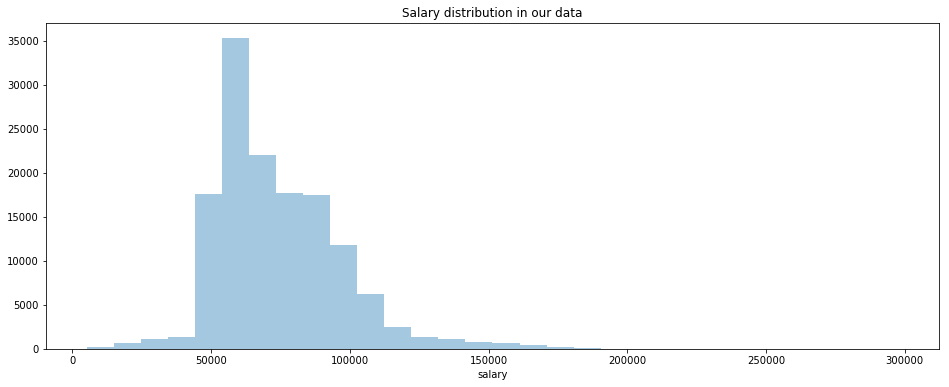

In [8]:
#Salary Distribution in dataset
#histogram
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt


h = sns.distplot(input_data['salary'], bins=30, kde=False)
plt.title('Salary distribution in our data')
h.figure.set_size_inches(16,6)
plt.show()

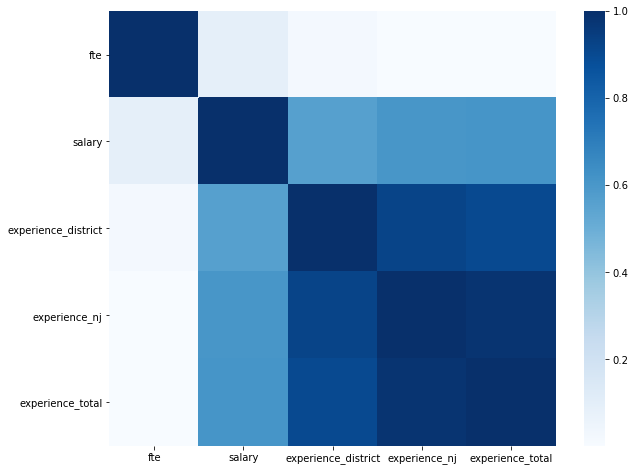

In [9]:

# visulize correlations of features with a heatmap# visuli 
plt.figure(figsize=(10,8))
sns.heatmap(input_data.corr(), cmap="Blues")
plt.show()


In [10]:
#Using label encoder for my categorical data which has more than two values
#Encode County first:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#there are some blanks in our certificate column, so replace by word blank where
# we will label encode them anyway 
input_data.certificate.fillna(value='blank', inplace=True)
input_data.fte.fillna(value=0, inplace=True)
input_data.salary.fillna(value=0, inplace=True)
input_data.experience_district.fillna(value=0, inplace=True)
input_data.experience_nj.fillna(value=0, inplace=True)
input_data.experience_total.fillna(value=0, inplace=True)
input_data['county']= le.fit_transform(input_data['county'])
input_data['district'] = le.fit_transform(input_data['district'])
input_data['school'] = le.fit_transform(input_data['school'])
input_data['primary_job'] = le.fit_transform(input_data['primary_job'])
input_data['certificate'] =le.fit_transform(input_data['certificate'])
input_data['subcategory'] = le.fit_transform(input_data['subcategory'])
input_data['teaching_route'] = le.fit_transform(input_data['teaching_route'])
input_data['highly_qualified'] = le.fit_transform(input_data['highly_qualified'])
#xx= list(le.inverse_transform(x))
#print(np.unique(xx))
#print(np.unique(x))

#input_data['county']= county

In [ ]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(input_data)



# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

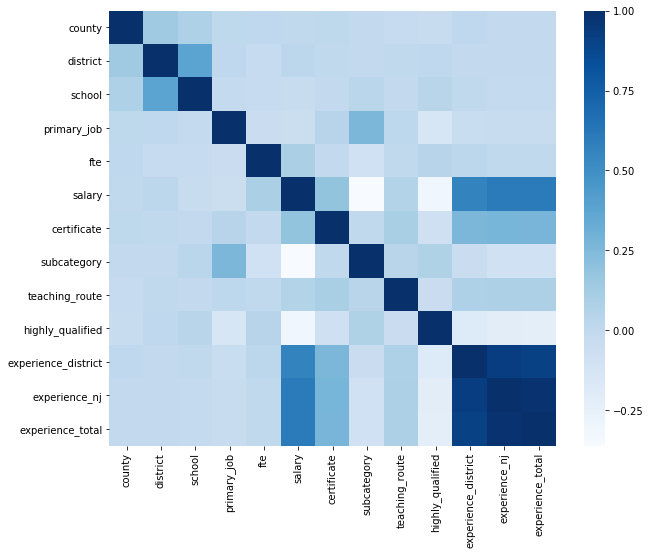

In [11]:
# visulize correlations of features with a heatmap# visuli 
#pd.scatter_matrix(input_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
plt.figure(figsize=(10,8))
sns.heatmap(input_data.corr(), cmap="Blues")
#sns.heatmap(input_data.corr())
plt.show()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Fitting Random Forest Regression to the dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
input_data = input_data[input_data['salary']>5000]
y= input_data['salary']
x=input_data.drop(['salary'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, 
test_size=0.25, random_state=0) 

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)


regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,oob_score=True)
regressor.fit(x_train, y_train)

# Predicting a new result
y_pred = regressor.predict(x_test)

regressor.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 1,
 'oob_score': True,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [21]:
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_pred))


Test RMSE: 10557.018
Test r^2 score: 0.786


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [50, 200],
    # 'n_estimators': [100, 200, 500],
    #'max_features': ['sqrt', 'log2']
}

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
scoring = {'AUC': 'roc_auc', 'F1':'f1', 'Acc':'accuracy'}


# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_parameters_`` and
# ``gs.best_index_``
gs = GridSearchCV(regressor, param_grid=param_grid, verbose=3,
                  scoring=scoring, cv=5)




In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
input_data = input_data[input_data['salary']>5000]
y= input_data['salary']
x=input_data.drop(['salary'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, 
test_size=0.25, random_state=0) 

from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)


regressor = RandomForestRegressor(n_estimators = 100, random_state = 0,oob_score=True)
regressor.fit(x_train, y_train)

param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,30,40,50],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10,100,200]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
gs = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [17]:
gs = gs.fit(x_train, y_train)


Fitting 3 folds for each of 270 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 26.0min finished


In [19]:
print(gs.best_score_)
print(gs.best_params_)

0.7546610619406282
{'max_features': 3, 'max_depth': 30, 'n_estimators': 200, 'bootstrap': True, 'min_samples_split': 8, 'min_samples_leaf': 3}


In [1]:
from sklearn import svm
svr_regressor= svm.SVR(kernel='rbf',cache_size=7000)
svr_regressor.fit(x_train, y_train) 

y_pred = svr_regressor.predict(x_test)
#array([ 1.5])
print(svr_regressor.score(x_test, y_test))

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(y_test, y_pred))

NameError: name 'x_train' is not defined

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
def baseline_model():
    model = Sequential()
    model.add(Dense(6, input_dim=12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# fix random seed for reproducibility
seed = 7

np.random.seed(seed)
estimators = []
estimators.append(('minmax', MinMaxScaler(feature_range=(-1, 1))))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=30, batch_size=5, verbose=2)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=2, random_state=seed)
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/30
 - 11s - loss: 1816140547.1715
Epoch 2/30
 - 11s - loss: 428009968.7274
Epoch 3/30
 - 10s - loss: 328144463.8648
Epoch 4/30
 - 10s - loss: 289934946.9895
Epoch 5/30
 - 9s - loss: 267936463.5381
Epoch 6/30
 - 10s - loss: 255994899.0432
Epoch 7/30
 - 10s - loss: 249383009.3079
Epoch 8/30
 - 10s - loss: 244140350.6805
Epoch 9/30
 - 10s - loss: 238345324.3282
Epoch 10/30
 - 10s - loss: 231231416.3471
Epoch 11/30
 - 10s - loss: 223112022.5885
Epoch 12/30
 - 10s - loss: 214939974.9744
Epoch 13/30
 - 10s - loss: 208130534.9227
Epoch 14/30
 - 10s - loss: 202997450.7614
Epoch 15/30
 - 10s - loss: 199286649.0216
Epoch 16/30
 - 10s - loss: 196832771.9063
Epoch 17/30
 - 10s - loss: 194994682.5104
Epoch 18/30
 - 10s - loss: 193722912.6673
Epoch 19/30
 - 10s - loss: 192870461.5222
Epoch 20/30
 - 10s - loss: 192291478.2869
Epoch 21/30
 - 10s - loss: 191841946.1270
Epoch 22/30
 - 10s - loss: 191520801.0934
Epoch 23/30
 - 10s - loss: 191245128.4358
Epoch 24/30
 - 10s - loss: 191033651.1519
E

In [ ]:

y_pred = pipeline.predict(X_test)

In [ ]:
from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
train_predict = pipeline.predict(X)

rmse = math.sqrt(mean_squared_error(Y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
print('Test r^2 score: %.3f' % r2_score(Y_test, y_pred))